# ExploreCSR: Evaluating the effectiveness of various ML models in detecting and classifying hate speech in Levantine Arabic

In [2]:
# load datasets 

path = "dataset/L-HSAB.txt"

import pandas as pd
 
df = pd.read_table(path, delimiter="	")

df

,Tweet,Class
0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,abusive
1,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,normal
2,و مصلحة لبنان تبدأ باستخراج النفط و الغاز لوقف...,normal
3,وليد جنبلاط كاتب الحكمة يا قذر,abusive
4,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشك...,abusive
...,...,...
5841,أمير المليشيا مش خائن,normal
5842,صدقت يناسبك جدا جدا,normal
5843,لبخليني حب باسيل شغلتين,normal
5844,ليش تيوس الإمارت والسعودية مع السوريين واليمني...,hate


In [3]:
# describe the data

df.describe()

,Tweet,Class
count,5846,5846
unique,5754,3
top,نجحنا بقوتنا شكراً فخامة الرئيس ومعالي الوزير ...,normal
freq,3,3650


In [4]:
# check null values

df.isnull().sum()

Tweet    0
Class    0
dtype: int64

In [5]:
# check duplicate reviews

df.duplicated().sum()

88

In [6]:
# Print duplicates to see what's happening and to check if they have the same sentiment

# Identify duplicates in the 'Tweet' column
duplicated_tweets = df["Tweet"].duplicated(keep=False)  # `keep=False` marks all duplicates as True

# Filter the DataFrame to keep only duplicates
duplicates_df = df[duplicated_tweets]

# Sort the DataFrame based on the 'Tweet' column to group duplicates together for easier inspection
duplicates_df_sorted = duplicates_df.sort_values(by="Tweet")

duplicates_df_sorted

,Tweet,Class
292,آخر فضيحة,normal
5214,آخر فضيحة,normal
3217,أصحاب الرؤوس الفارغة ما عندا شي غير تهاجم الوز...,normal
4901,أصحاب الرؤوس الفارغة ما عندا شي غير تهاجم الوز...,normal
1763,أمير قطر يأتي بأوامر أمريكية لمهمة محددة وهي ت...,normal
...,...,...
5550,يجب أن يعلم الجميع أن الشجرة المثمرة ترشق دائم...,normal
1185,يقصف عمرك ما انتنك,abusive
1867,يقصف عمرك ما انتنك,abusive
4867,يلي بدو يخوّن جبران باسيل بدو يسمع الجواب,normal


In [7]:
# Remove duplicated tweets based on the 'Tweet' column, keeping the first occurrence
df = df.drop_duplicates(subset='Tweet', keep='first')

# Print the shape of the cleaned DataFrames to see the number of rows removed
print(f"Cleaned DataFrame shape: {df.shape}")

Cleaned DataFrame shape: (5754, 2)


In [8]:
# Print the unique values and their counts for the 'Class' column 

# Get counts and percentages of unique values in the 'Class' column
sentiment_counts = df['Class'].value_counts()
sentiment_percentages = df['Class'].value_counts(normalize=True) * 100

# Print the counts and percentages
print("Counts of unique sentiment values:")
print(sentiment_counts)
print("\nPercentages of unique sentiment values:")
print(sentiment_percentages)

Counts of unique sentiment values:
Class
normal     3576
abusive    1713
hate        465
Name: count, dtype: int64

Percentages of unique sentiment values:
Class
normal     62.148071
abusive    29.770594
hate        8.081335
Name: proportion, dtype: float64


In [9]:
# Check for outliers in tweet length

# Calculate the length of each tweet
df['Tweet_Length'] = df['Tweet'].apply(len)

/var/folders/1d/sjc73vvj2l702mjqyjpnncjw0000gn/T/ipykernel_25239/83635518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tweet_Length'] = df['Tweet'].apply(len)


In [10]:
# Get descriptive analysis 

df['Tweet_Length'].describe()

count    5754.000000
mean       63.683351
std        37.828235
min         3.000000
25%        32.000000
50%        57.000000
75%        93.000000
max       277.000000
Name: Tweet_Length, dtype: float64

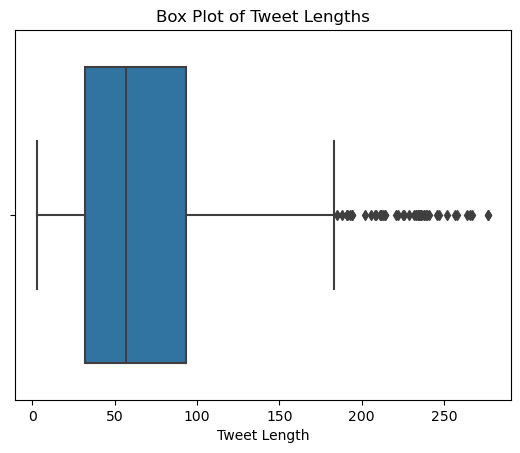

In [11]:
# Plot Tweet Lengths

import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=df['Tweet_Length'])
plt.title('Box Plot of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.show()

In [12]:
# IQR method for identifying outliers

# Calculate the first and third quartile
Q1 = df['Tweet_Length'].quantile(0.25)
Q3 = df['Tweet_Length'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the bounds for non-outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Tweet_Length'] < lower_bound) | (df['Tweet_Length'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")

Number of outliers: 49


In [13]:
# Remove outliers 

# Filter the DataFrame to remove outliers
df = df[(df['Tweet_Length'] >= lower_bound) & (df['Tweet_Length'] <= upper_bound)]

# Print the shape of the cleaned DataFrames to see the number of rows removed
print(f"Cleaned DataFrame shape: {df.shape}")

Cleaned DataFrame shape: (5705, 3)


In the preprocessing stage of our sentiment analysis task, we have decided to modify the classification structure of our dataset. Originally, the dataset contained three labels for text classification: 'Hate', 'Abusive', and 'Normal'. To enhance the effectiveness and applicability of our analysis, we are combining the 'Hate' and 'Abusive' labels into a single 'Hate' label, resulting in a binary classification system. This decision is grounded in several key considerations outlined below.

### Simplification of the Classification Task
By reducing the number of classes from three to two, we simplify the classification task. This simplification can lead to more robust and generalized models, as the model now needs to distinguish between only two categories rather than three. This can be particularly beneficial if the dataset is imbalanced or if there is a significant overlap between the 'Abusive' and 'Hate' categories, which can make it challenging for the model to differentiate between them accurately.

### Conceptual Overlap
'Abusive' and 'Hate' tweets, while distinct in their definitions, share considerable conceptual overlap. Both involve offensive, aggressive, insulting, or profanity content, with the primary difference being that 'Hate' tweets are directed at specific individuals or groups based on identity characteristics. By combining these categories, we acknowledge this overlap and focus on the shared characteristics of these types of speech, namely their potential to cause harm or perpetuate discrimination and prejudice.

### Focus on Severity
Combining 'Abusive' and 'Hate' tweets into a single 'Hate' category allows the research to focus on the most severe forms of negative online behavior. Hate speech, which includes abusive language and targets individuals or groups based on identity, is often considered more harmful than general abusive speech due to its potential to incite violence, discrimination, and societal division. By focusing on this category, our research aligns with broader societal concerns regarding online behavior and its impact.

### Practical Considerations
From a practical standpoint, binary classification models are often easier to implement, interpret, and explain. This can be particularly advantageous when communicating findings to a non-technical audience, such as policymakers or social media platform administrators, who might be interested in applying your research to develop or refine content moderation policies.

### Alignment with Research Goals
By focusing on the most severe and impactful forms of negative speech, our research can contribute more directly to efforts aimed at creating safer and more inclusive online environments.

In [14]:
# Replacing 'Abusive' with 'Hate' in the 'Class' column
df['Class'] = df['Class'].replace({'abusive': 'hate'})

# Display the updated DataFrame
df

,Tweet,Class,Tweet_Length
0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,hate,96
1,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,normal,87
2,و مصلحة لبنان تبدأ باستخراج النفط و الغاز لوقف...,normal,104
3,وليد جنبلاط كاتب الحكمة يا قذر,hate,31
4,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشك...,hate,52
...,...,...,...
5840,اسم الله عليك فرجيني عرض كتافك يا فهيم على فكر...,normal,85
5841,أمير المليشيا مش خائن,normal,21
5842,صدقت يناسبك جدا جدا,normal,20
5843,لبخليني حب باسيل شغلتين,normal,23


In [15]:
# Print the unique values and their counts for the 'Class' column 

# Get percentages of unique values in the 'Class' column
sentiment_counts = df['Class'].value_counts()
sentiment_percentages = df['Class'].value_counts(normalize=True) * 100

print("Percentages of unique sentiment values:")
print(sentiment_percentages)

Percentages of unique sentiment values:
Class
normal    62.383874
hate      37.616126
Name: proportion, dtype: float64


#### Note on Data Balancing Considerations
As observed in the preliminary data analysis, the distribution of unique sentiment values in our dataset shows a notable imbalance:

* Normal: 62.38%

* Hate: 37.62%


This skew in the dataset may potentially introduce bias into our model, affecting its ability to generalize and accurately classify unseen data. In the interest of prioritizing model development and iteration speed, we will proceed without implementing data balancing techniques in the initial phases. This approach will allow us to establish a performance baseline for our model.

However, it is important to acknowledge that the imbalance in our dataset might lead to suboptimal model performance, particularly in its ability to accurately identify instances of the minority class ('Hate' sentiments in this case). Should the model exhibit poor performance, particularly for the minority class, revisiting and applying data balancing techniques will be imperative.

Potential data balancing strategies to consider include:

- Oversampling the minority class
- Undersampling the majority class
- Utilizing synthetic data generation techniques (e.g., SMOTE)
- Applying cost-sensitive learning or adjusting class weights

## Text Preprocessing

### Overview
The preprocessing pipeline includes the following steps:

1. **Strip Tashkeel**
2. **Strip Tatweel**
3. **Remove Punctuations**
4. **Normalize Arabic**
5. **Remove Emoji**
6. **Remove Numbers**
7. **Remove English Letters**

Each step is designed to address specific aspects of the text data, ensuring that the final output is clean and standardized for further processing or analysis.

### 1. Strip Tashkeel
- **Description**: Removes Arabic diacritical marks (Tashkeel) from the text. Tashkeel includes marks that denote vowel sounds, which are not usually needed for text analysis tasks.
- **Function**: `strip_tashkeel(text: str) -> str`
- **Example**:
  - Input: "الْعَرَبِيَّةُ"
  - Output: "العربية"

### 2. Strip Tatweel
- **Description**: Eliminates the Tatweel (Kashida) character from Arabic text. The Tatweel is a formatting character that extends the connection between letters, commonly used for aesthetic purposes.
- **Function**: `strip_tatweel(text: str) -> str`
- **Example**:
  - Input: "العــــربية"
  - Output: "العربية"

### 3. Remove Punctuations
- **Description**: Strips all punctuation marks from the text, including both standard English and Arabic punctuation characters. This step simplifies text analysis by focusing on textual content without punctuation.
- **Function**: `remove_punctuations(text: str) -> str`
- **Example**:
  - Input: "مرحبا، كيف حالك؟"
  - Output: "مرحبا كيف حالك"

### 4. Normalize Arabic
- **Description**: Applies normalization rules specific to Arabic text, such as replacing Alef Maksura with Ya and Teh Marbuta with Heh. This step standardizes variations of similar characters.
- **Function**: `normalize_arabic(text: str) -> str`
- **Example**:
  - Input: "الأرض"
  - Output: "الارض"

### 5. Remove Emoji
- **Description**: Filters out emoji characters from the text. Since emojis can introduce noise into text analysis, removing them can help in focusing on the textual data.
- **Function**: `remove_emoji(text: str) -> str`
- **Example**:
  - Input: "أنا سعيد 😊"
  - Output: "أنا سعيد "

### 6. Remove Numbers
- **Description**: Deletes both Arabic and English numeric characters from the text. This is particularly useful in analyses where numeric data is irrelevant.
- **Function**: `remove_nums(text: str) -> str`
- **Example**:
  - Input: "لدي ١٠ تفاحات"
  - Output: "لدي تفاحات"

### 7. Remove English Letters
- **Description**: Strips out all English alphabetic characters. This step is useful in processing texts where only non-English characters are of interest.
- **Function**: `remove_english_letters(text: str) -> str`
- **Example**:
  - Input: "اللغة العربية Arabic Language"
  - Output: "اللغة العربية  "

### Implementation Notes
Each preprocessing function is designed to be applied independently, allowing for flexible configuration of the preprocessing pipeline based on specific requirements. The functions can be composed in sequence to prepare texts for various NLP tasks such as tokenization, sentiment analysis, or topic modeling.

The preprocessing steps detailed above are essential for cleaning and standardizing text data, particularly when dealing with multilingual datasets. By applying these steps, the text data is made more uniform, thereby improving the performance of downstream NLP tasks.


In [16]:
pip install pyarabic

Note: you may need to restart the kernel to use updated packages.


In [17]:
import string 

def remove_punctuations(text: str) -> str:
    # This function removes Arabic & English punctuations from a string 
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [18]:
def normalize_arabic(text: str) -> str:
    # This function normalizes Arabic text by standardizing variations of Alif, Ya, Hamza, Taa Marbuta, and Kaf characters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [19]:
def remove_emoji(text: str) -> str:
    "This function removes emojis from a string"
    emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [20]:
import re

def remove_nums(text: str) -> str:
    "This function removes Arabic and English numbers from a string"
    text = re.sub('[\u0661-\u0669]+', '', text)          # remove Arabic numbers
    text = ''.join(i for i in text if not i.isdigit())   # remove English numbers 
    return text 

In [21]:
def remove_english_letters(text: str) -> str:
    # This function replace any English letters with an empty string
    return re.sub('[a-zA-Z]', '', text)

In [22]:
from typing import Callable, Dict, List
from pyarabic.araby import strip_tashkeel, strip_tatweel

def count_preprocessed_tweets(df: pd.DataFrame, preprocessing_functions: List[Callable[[str], str]]) -> Dict[str, int]:
    # This function counts the number of tweets in a DataFrame that are affected by each preprocessing function
    # A tweet is considered 'affected' by a preprocessing function if the function alters the tweet's content
    
    counts = {}  # Dictionary to store counts for each preprocessing function

    for function in preprocessing_functions:
        count = 0
        for text in df['Tweet']:
            if text != function(text):
                count += 1
        counts[function.__name__] = count  # Store count with function's name as key

    return counts


# List of preprocessing functions to apply
preprocessing_functions = [strip_tashkeel, strip_tatweel, remove_punctuations, normalize_arabic, remove_emoji, remove_nums, remove_english_letters]

# Apply the function to the dataframe
counts = count_preprocessed_tweets(df, preprocessing_functions)

# Print the results
for function_name, count in counts.items():
    print(f"Number of tweets affected by {function_name}: {count}")


Number of tweets affected by strip_tashkeel: 495
Number of tweets affected by strip_tatweel: 8
Number of tweets affected by remove_punctuations: 809
Number of tweets affected by normalize_arabic: 4049
Number of tweets affected by remove_emoji: 66
Number of tweets affected by remove_nums: 1
Number of tweets affected by remove_english_letters: 0


In [23]:
def preprocess_text(text: str) -> str:
    # This function applies a series of text preprocessing steps to the input text
    text = strip_tashkeel(text)
    text = strip_tatweel(text)
    text = remove_punctuations(text)
    text = normalize_arabic(text)
    text = remove_emoji(text)
    text = remove_nums(text)
    text = remove_english_letters(text)
    return text 

In [24]:
# Apply the preprocess_text function to each tweet in the 'Tweet' column

df['Tweet'] = df['Tweet'].apply(preprocess_text)

In [25]:
# Apply tokenization to each tweet in the 'Tweet' column 

from pyarabic import araby

df['Tokenized_Tweet'] = df['Tweet'].apply(araby.tokenize)

In [26]:
# Explore applying stemming to each word in the 'Tokenized_Tweet' column (check first 50 words)

import nltk
nltk.download('isri')
from nltk.stem.isri import ISRIStemmer

stemmer = ISRIStemmer()

counter = 0  # Initialize a counter

for token in df['Tokenized_Tweet']:
    for word in token:
        if counter < 50:  # Check if counter is less than 50
            print(word, "vs", stemmer.stem(word))
            counter += 1  # Increment counter
        else:
            break  # Break out of the loop once 50 words have been processed
    if counter >= 50:  # Check if counter has reached 50 to stop processing further rows
        break

الوزير vs وزر
جبران vs جبر
باسيل vs اسل
تاج vs تاج
راسك vs رسك
يا vs يا
جربان vs جرب
ممنوع vs منع
بعد vs بعد
اليوم vs اليوم
المساس vs ساس
بمقدساتنا vs قدس
من vs من
ربنا vs ربن
والهنا vs هنا
يسوع vs يسع
المسيح vs سيح
صديقي vs صدق
انت vs انت
ابن vs ابن
جامعه vs جمع
اللعبه vs لعب
اكبر vs كبر
من vs من
داعش vs دعش
اللعبه vs لعب
سنيه vs سنه
شيعيه vs شيع
واعاده vs اعد
توزيع vs وزع
ديموغرافي vs ديموغرافي
بسوريا vs بسر
و vs و
مصلحه vs صلح
لبنان vs لبن
تبدا vs تبد
باستخراج vs باستخراج
النفط vs نفط
و vs و
الغاز vs غاز
لوقف vs وقف
الشحاده vs شحد
و vs و
هذه vs هذه
نقطه vs نقط
ضعف vs ضعف
لبنان vs لبن
ليبقي vs يبق
رهن vs رهن
سياسات vs سيس


[nltk_data] Error loading isri: Package 'isri' not found in index


#### Note on Stemming and Lemmatization 

Stemming and lemmatization are key preprocessing steps in sentiment analysis tasks, aimed at reducing words to their base forms. However, their effectiveness varies due to the rich morphology of Arabic.

* Stemming: This process trims prefixes and suffixes. While tools like the ISRIStemmer are commonly used, they can overly simplify words, making them vague and potentially distorting the intended sentiment.

* Lemmatization: A more sophisticated approach that considers the word's morphological analysis to return its base form. It is more accurate than stemming but requires more computational resources.

**Note: The complexity of Levantine Arabic poses challenges to both stemming and lemmatization, necessitating a careful balance between word normalization and the preservation of linguistic nuances.**

For this project, we will proceed without applying stemming to avoid oversimplification of words. Should the model exhibit poor performance, revisiting and potentially applying stemming will be considered to enhance linguistic normalization while being mindful of the balance between word simplification and the retention of meaningful content.

#### Arabic Stop Words Source

In the next cell, we utilize an Arabic stop words list obtained from Mohamad Alhakim's "arabic-stop-words" GitHub repository. The decision to use this external source was driven by the limited availability of comprehensive Arabic stop words lists in common NLP libraries and tools. The inclusion of this list could significantly improve text preprocessing by effectively filtering out common but low-information words, thereby enhancing the focus on meaningful content analysis.

**Source**: [GitHub - arabic-stop-words](https://github.com/mohataher/arabic-stop-words/tree/master)

In [27]:
# Define an empty list to store the stop words
arabic_stop_words = []

# Open the text file and read each line in the file
with open('arabic_stopwords_list.txt', 'r', encoding='utf-8') as file:
    for line in file:
        arabic_stop_words.append(preprocess_text(line.strip()))

# print(arabic_stop_words)

### Bag of Words (BoW) Implementation 

This section of the project implements the Bag of Words (BoW) model to convert the text data from the `tweets` column of our DataFrame `df` into a numerical format that can be used for further analysis or machine learning tasks. 

**Overview**:

The Bag of Words (BoW) model is a fundamental NLP technique that transforms text into fixed-length vectors by counting how many times each word appears in a document. It disregards the order and context of words, focusing solely on word frequencies or presence within the document set, thus forming a "bag." This numerical representation enables computational and machine learning methods to process and analyze text data efficiently.

**Purpose and Usage**:

The BoW model is instrumental in transforming textual data into a numerical format, allowing for quantitative analysis and the application of various machine learning algorithms. By converting tweets into vectors of word counts while excluding common stop words, we retain the essential textual information in a form that's amenable to computational methods.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with a list of stop words to exclude from analysis
vectorizer = CountVectorizer(stop_words=arabic_stop_words)

# Extract the 'Tweet' column from the DataFrame to process
tweets = df['Tweet']

# Fit the vectorizer to the tweets and transform them into a sparse matrix of word counts
bow = vectorizer.fit_transform(tweets)

# Convert the sparse matrix to a dense array for easier manipulation and access
bow_array = bow.toarray()

# Retrieve the list of all words that constitute the vocabulary of the dataset
vocabulary = vectorizer.get_feature_names_out()

/Users/ahmed/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['افعل', 'افعله', 'انفك', 'برح', 'سيما'] not in stop_words.
  warnings.warn(


In [29]:
import numpy as np

# Sum the occurrences of each word across all documents to get total word counts
word_counts = np.sum(bow_array, axis=0)

# Get indices that would sort the word counts array in descending order
sorted_indices = np.argsort(word_counts)[::-1]

# Use sorted indices to arrange words in order of descending frequency
sorted_words = vocabulary[sorted_indices]

# Apply sorted indices to word counts to align with sorted vocabulary
sorted_counts = word_counts[sorted_indices]

# Define the number of top common words to display
num_top_words = 50

# Print the top N most common words and their corresponding counts
print("Most common words:")
for i in range(num_top_words):
    print(f"{sorted_words[i]}: {sorted_counts[i]}")

Most common words:
يا: 1302
جبران: 1016
باسيل: 1014
شو: 368
الله: 344
عم: 313
لبنان: 266
مش: 231
وهاب: 207
هوا: 202
كول: 193
شي: 180
قطر: 178
الوزير: 164
انو: 162
كلب: 158
مين: 149
وءام: 143
هيك: 134
متل: 134
سوريا: 132
والله: 124
وزير: 123
حدا: 120
روح: 106
اسراءيل: 105
هيدا: 105
دوله: 104
الرءيس: 104
اللي: 101
بدك: 96
بلا: 96
عون: 93
عثمان: 92
يعني: 87
القمه: 85
العربيه: 83
انك: 82
منك: 82
لازم: 80
وانت: 79
كنت: 77
ابن: 77
حمار: 75
الخارجيه: 73
بشار: 73
رح: 70
حق: 70
ولك: 70
الاسد: 69


In [30]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install arabic-reshaper python-bidi

Note: you may need to restart the kernel to use updated packages.


In [32]:
# Create a dictionary of word frequencies.
word_frequencies = {word: count for word, count in zip(sorted_words, sorted_counts)}

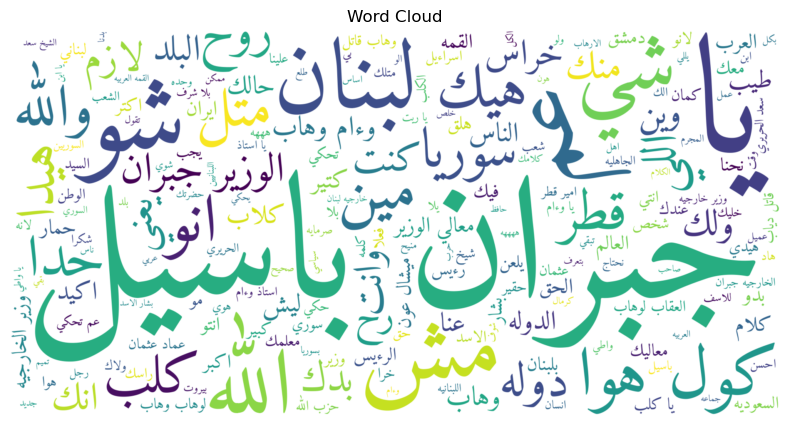

In [34]:
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Manually filter out stop words before reshaping
filtered_tweets = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in arabic_stop_words]))

# Join the tweets into a single string, then reshape
data = " ".join(filtered_tweets.apply(arabic_reshaper.reshape))

# Apply the BiDi algorithm for correct right-to-left display
data = get_display(data)

# Generate the word cloud without specifying stop words this time (as they've been manually removed)
wordcloud = WordCloud(
    font_path='/Users/ahmed/Downloads/Amiri/Amiri-Regular.ttf',
    background_color='white',
    mode='RGB',
    width=2000,
    height=1000
).generate(data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.title("Word Cloud")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()